# Movie Tickets Visualization

For the second week, I decided to use data I have personally collected. I'm a big fan of movies and I want to make sense of my data to get insights on my viewing preferences (and slightly curious as well on how much I've spent already on watching movies). My dataset is a bit of small so I teamed up with a friend to analyze our viewing preferences. It is still a bit small and I stopped collecting after August of last year, but for the sake of practice, I'll be proceeding anyway for the analysis.

Disclaimer: I realized that the dataset is really small; thus the results will not generalize my friend and I's viewing preferences. I started collecting since April of 2016 and stopped at August of 2017. There is a possibility that I may have missed possible entries in the dataset (failed to take note or collect movie tickets) so the results does not really conclude anything. 

First, I'll load the necessary files and libraries.

In [88]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, ColorConverter
import re
import matplotlib.dates as dates
from matplotlib.ticker import MaxNLocator
%matplotlib inline

pd.set_option('display.max_columns', None)

In [92]:
path = os.getcwd() + '/movietickets.csv'
movies = pd.read_csv(path, lineterminator='\n', encoding='latin-1')
movies.shape

(27, 8)

I've listed a few questions that I want answers from my dataset:
1. How many movies have each person watched?
2. What is the total cost spent on movie by each person?
3. What months do users commonly watch movies in theaters?
4. What are the different and similar movies watched by the users?
5. What movie theaters are the most common?
6. What time frames do users usually watch movies?

### 1. How many movies have each person watched?

The total number of movies watched aggregates the unique occurrence of a movie by a person. This does not sum up the number of tickets bought by the user.

To get the total number of movies, we group the dataset by each person and get the movie count.

In [93]:
num_movies_watched = movies.groupby('User').agg({'Movie': 'nunique'}).reset_index()
num_movies_watched

,User,Movie
0,Bianca,11
1,Kharl,15


I've seen 11 movies in theaters during the timeframe of April 2016 - August 2017 while Kharl has seen 15 movies. This means that on average, Kharl watches a movie on theaters once a month (plus a rest month on this timeframe). 

### 2. What is the total cost spent on movie by each person?

Now here's the most important part, how much did we spend on movies during this timeframe? Note that the total cost spent only counts one ticket per purchase. To get this, I simply added the total cost per person.

In [94]:
total_cost = pd.DataFrame(movies.groupby(['User'])['Cost'].sum()).reset_index()
total_cost

,User,Cost
0,Bianca,2254
1,Kharl,3516


If we divide the total cost to the number of movies, I spend P204 for each movie ticket, on average. Kharl, on the other hand, spends P234 for each movie ticket on average. That's a P30 difference in the prices, maybe switch to a new theater instead?

### 3. What months do users commonly watch movies in theaters?

What month do we usually watch movies? I'm guessing it's on May because most blockbuster movies release during the summer, specifically May. But let the data do the talking.

First, let's clean the data and convert the Date column to the %d/%m/%y format using the following code.

In [95]:
movies['Date'] = pd.to_datetime(movies['Date'], format='%d/%m/%Y')

Then, we can split the Date column to get the months only.

In [111]:
movies['Year'] = movies['Date'].dt.year
movies['Month'] = movies['Date'].dt.month

Afterwards, we can now get the movie count per month per person.

In [112]:
month_bianca = movies.loc[movies['User'] == 'Bianca']['Month']
month_kharl = movies.loc[movies['User'] == 'Kharl']['Month']
months = np.arange(12)
months_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oc', 'Nov', 'Dec']

I updated the data so that the months that do not appear on my data get 0 count.

In [113]:
b = movies.loc[movies['User'] == 'Bianca']
k = movies.loc[movies['User'] == 'Kharl']
month_bianca_count = []
month_kharl_count = []

for i in range(1, 13):
    month_bianca_count.append(len(b.loc[b['Month'] == i]))
    month_kharl_count.append(len(k.loc[k['Month'] == i]))

The first chart that came into mind was a simple multi bar chart comparing the number of movies we've seen per month. Below is the code used in plotting the bar chart.

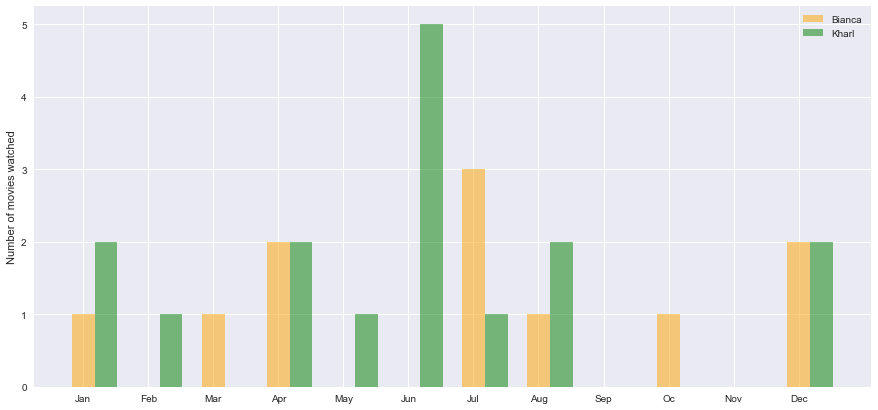

In [122]:
fig, ax = plt.subplots(figsize=(15,7))
width = 0.35
rects1 = ax.bar(months, month_bianca_count, width, color='orange', alpha=0.5)
rects2 = ax.bar(months + width, month_kharl_count, width, color='green', alpha=0.5)

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of movies watched')
ax.set_xticks(months)
ax.set_xticklabels(months_label)

ax.legend((rects1[0], rects2[0]), ('Bianca', 'Kharl'))

plt.savefig('bar_month_movies', dpi=300)
plt.show()

I was wrong! July was the month where I watched the most movies on theaters. Meanwhile, Kharl usually goes to theaters on June. I can't think of any possible explanation for this except that movies released in the middle of the year are usually blockbusters.

I made another chart in comparing the number of movies seen per month, but using a line chart. The code below shows how I plotted the line chart:

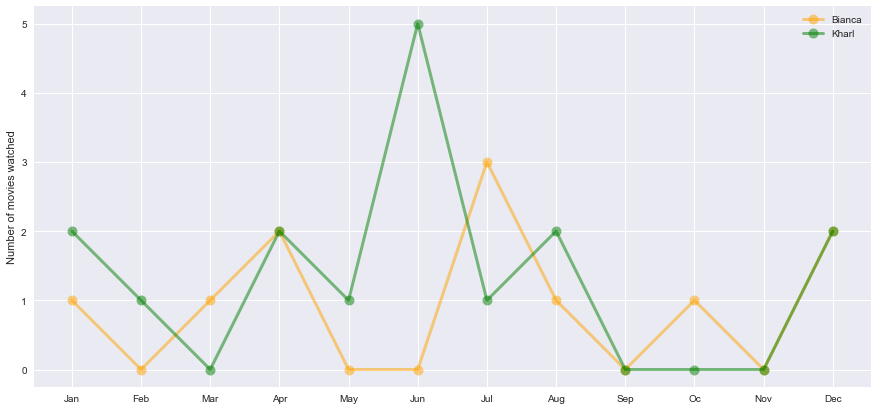

In [123]:
fig, ax = plt.subplots(figsize=(15,7))

line1 = plt.plot(months, month_bianca_count, marker='o', color='orange', alpha=0.5, linewidth=3, markersize=10)
line2 = plt.plot(months, month_kharl_count, marker='o', color='green', alpha=0.5, linewidth=3, markersize=10)
ax.set_xticks(months)
ax.set_xticklabels(months_label)
ax.legend((line1[0], line2[0]), ('Bianca', 'Kharl'))
plt.ylabel('Number of movies watched')

plt.savefig('line_month_movies', dpi=300)
plt.show()

### 4. What are the different and similar movies watched by the users?

For this part, I just want to know if we watch similar movies on cinemas. I used set intersection to get the common movies we have seen. 

In [118]:
# keep only matching rows
len(movies['Movie'].value_counts())
pd.Series(list(set(b['Movie']) & set(k['Movie'])))

0    Baby Driver
1     La La Land
2          Moana
dtype: object

Out of 23 total movies we watched in theaters, only 3 movies are common. Out of the 3, we watched 2 movies on the same theater. I initially thought we'd have similar movies seen so to find that only 3 are common was surprising.

### 5. What movie theaters are the most common?

I'm guessing Robinsons Place Manila would be the most common as Manila is the only place that is common to us. But I still want to know how frequent each person visits a certain theater.

In [119]:
# keep only matching rows
len(movies['Location'].value_counts())
pd.Series(list(set(b['Location']) & set(k['Location'])))

0    Robinsons Place Manila
dtype: object

The above code confirms that Robinsons Place Manila is the most common. 10 movies were seen in this theater, where 2 are common.

Next is to find how frequent we visit a certain movie theater. Below is the code used to generate a bar chart for the movies I've seen.

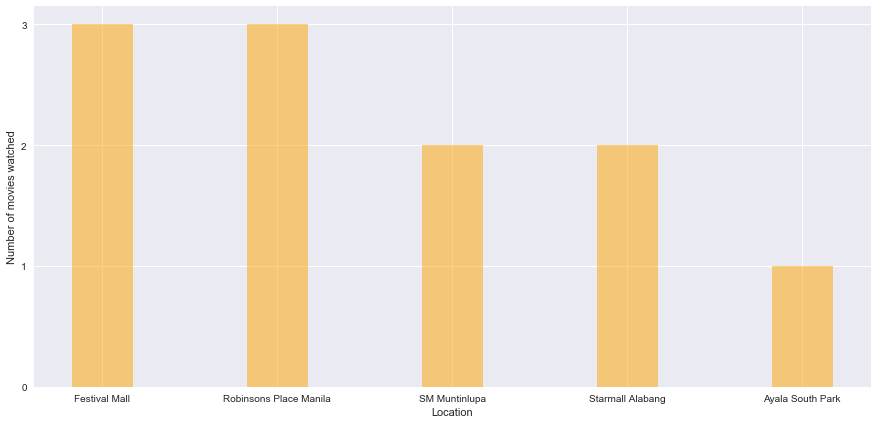

In [124]:
location_bianca = b['Location'].unique()
location_bianca_count = b['Location'].value_counts()
N = len(location_bianca)

fig, ax = plt.subplots(figsize=(15,7))
width = 0.35
rects1 = ax.bar(np.arange(N), location_bianca_count, width, color='orange', alpha=0.5)

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of movies watched')
ax.set_xlabel('Location')
ax.set_xticks(np.arange(N))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticklabels(location_bianca)

plt.savefig('bar_location_b_movies', dpi=300)
plt.show()

The bar chart looks even which means that I visit different movie theaters and not stick to one. I probably didn't have a favorite movie theater at that time. (I do now, though.)

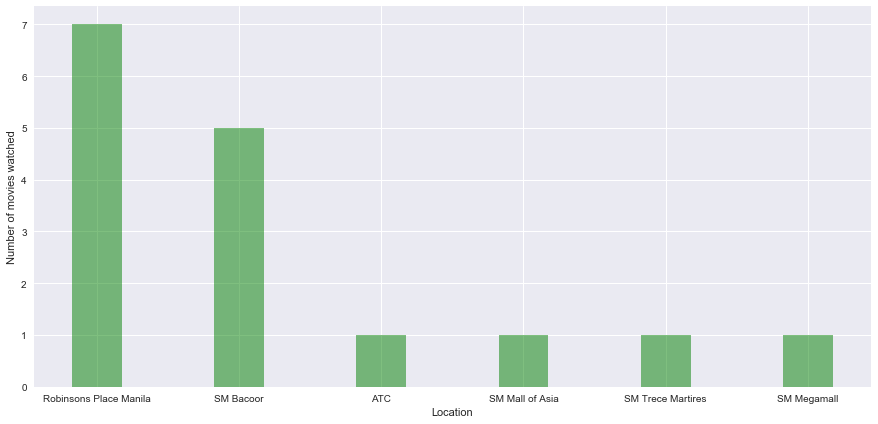

In [125]:
location_kharl = k['Location'].unique()
location_kharl_count = k['Location'].value_counts()
N = len(location_kharl)

fig, ax = plt.subplots(figsize=(15,7))
width = 0.35
rects1 = ax.bar(np.arange(N), location_kharl_count, width, color='green', alpha=0.5)

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of movies watched')
ax.set_xlabel('Location')
ax.set_xticks(np.arange(N))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xticklabels(location_kharl)

plt.savefig('bar_location_k_movies', dpi=300)
plt.show()

It says differently for Kharl. His most visited movie theater is Robinsons Place Manila, with a close second at SM Bacoor. Those must be his two favorite movie theaters (or we could also say that those two are the most convenient movie theaters).

That's it for today's challenge. I can't really conclude much about this because I have a very small dataset. But for this timeframe, I at least wanted to know my viewing preferences. The biggest takeaway I got here was the months that we usually watch movies. I wonder what's in June that caused a huge spike for Kharl's data. I was also surprised over the number of movies we've seen in common. 3 for me is a bit small; I guess we just have different preferences in movies.